# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [3]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [4]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
    'torchtext': '0.10.0'
}
check_packages(d)

[OK] Your Python version is 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
[OK] torch 1.10.0
[OK] torchtext 0.11.0


# Chapter 15: Modeling Sequential Data Using Recurrent Neural Networks (Part 2/3)

**Outline**

- [Implementing RNNs for sequence modeling in PyTorch](#Implementing-RNNs-for-sequence-modeling-in-PyTorch)
  - [Project one -- predicting the sentiment of IMDb movie reviews](#Project-one----predicting-the-sentiment-of-IMDb-movie-reviews)
    - [Preparing the movie review data](#Preparing-the-movie-review-data)
    - [Embedding layers for sentence encoding](#Embedding-layers-for-sentence-encoding)
    - [Building an RNN model](#Building-an-RNN-model)
    - [Building an RNN model for the sentiment analysis task](#Building-an-RNN-model-for-the-sentiment-analysis-task)
      - [More on the bidirectional RNN](#More-on-the-bidirectional-RNN)

In [2]:
from IPython.display import Image
%matplotlib inline

# Implementing RNNs for sequence modeling in PyTorch

## Project one: predicting the sentiment of IMDb movie reviews

### Preparing the movie review data



In [14]:
import torch
import torch.nn as nn

In [15]:
# !pip install torchtext

In [16]:
from torchtext.datasets import IMDB
from torch.utils.data.dataset import random_split

# Step 1: load and create the datasets

train_dataset = IMDB(split='train')
test_dataset = IMDB(split='test')

torch.manual_seed(1)
train_dataset, valid_dataset = random_split(
    list(train_dataset), [20000, 5000])


In [17]:
## Step 2: find unique tokens (words)
import re
from collections import Counter, OrderedDict

token_counts = Counter()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized


for label, line in train_dataset:
    tokens = tokenizer(line)
    token_counts.update(tokens)
 
    
print('Vocab-size:', len(token_counts))

Vocab-size: 69023


In [18]:
## Step 3: encoding each unique token into integers
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

print([vocab[token] for token in ['this', 'is', 'an', 'example']])

[11, 7, 35, 457]


In [19]:
## Step 3-A: define the functions for transformation

device = torch.device("cuda:0")
# device = 'cpu'

text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: 1. if x == 'pos' else 0.


## Step 3-B: wrap the encode and transformation function
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), 
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [20]:
## Take a small batch

from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))
print(text_batch)
print(label_batch)
print(length_batch)
print(text_batch.shape)

tensor([[   35,  1739,     7,   449,   721,     6,   301,     4,   787,     9,
             4,    18,    44,     2,  1705,  2460,   186,    25,     7,    24,
           100,  1874,  1739,    25,     7, 34415,  3568,  1103,  7517,   787,
             5,     2,  4991, 12401,    36,     7,   148,   111,   939,     6,
         11598,     2,   172,   135,    62,    25,  3199,  1602,     3,   928,
          1500,     9,     6,  4601,     2,   155,    36,    14,   274,     4,
         42945,     9,  4991,     3,    14, 10296,    34,  3568,     8,    51,
           148,    30,     2,    58,    16,    11,  1893,   125,     6,   420,
          1214,    27, 14542,   940,    11,     7,    29,   951,    18,    17,
         15994,   459,    34,  2480, 15211,  3713,     2,   840,  3200,     9,
          3568,    13,   107,     9,   175,    94,    25,    51, 10297,  1796,
            27,   712,    16,     2,   220,    17,     4,    54,   722,   238,
           395,     2,   787,    32,    27,  5236,  

In [21]:
## Step 4: batching the datasets

batch_size = 32  

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

### Embedding layers for sentence encoding


 * `input_dim`: number of words, i.e. maximum integer index + 1.
 * `output_dim`: 
 * `input_length`: the length of (padded) sequence
    * for example, `'This is an example' -> [0, 0, 0, 0, 0, 0, 3, 1, 8, 9]`   
    => input_lenght is 10
 
 

 * When calling the layer, takes integr values as input,   
 the embedding layer convert each interger into float vector of size `[output_dim]`
   * If input shape is `[BATCH_SIZE]`, output shape will be `[BATCH_SIZE, output_dim]`
   * If input shape is `[BATCH_SIZE, 10]`, output shape will be `[BATCH_SIZE, 10, output_dim]`

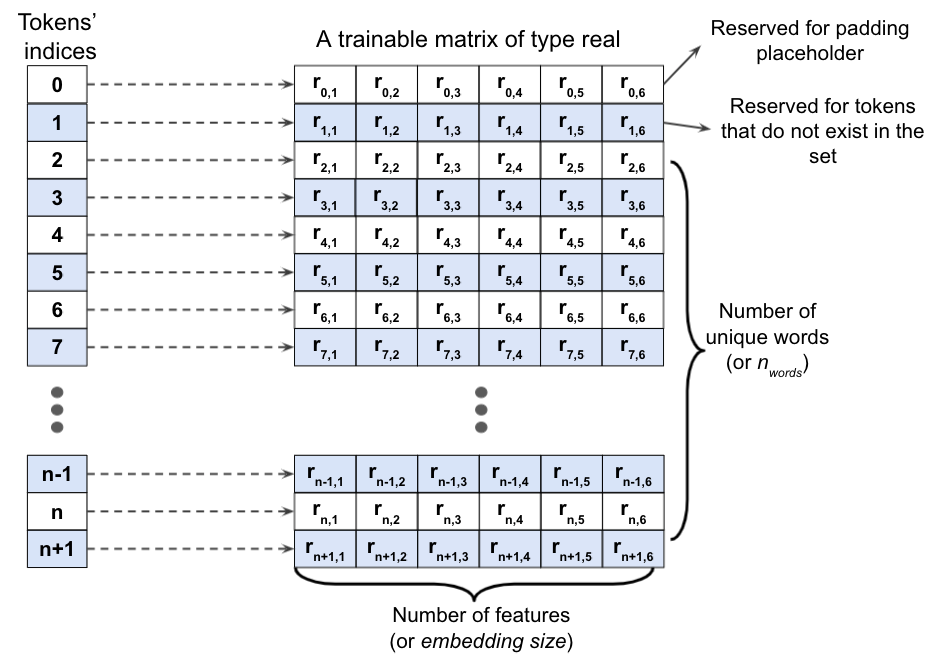

In [22]:
Image(filename='figures/15_10.png', width=700)

In [23]:
embedding = nn.Embedding(num_embeddings=10, 
                         embedding_dim=3, 
                         padding_idx=0)
 
# a batch of 2 samples of 4 indices each
text_encoded_input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
print(embedding(text_encoded_input))


tensor([[[ 0.7039, -0.8321, -0.4651],
         [-0.3203,  2.2408,  0.5566],
         [-0.4643,  0.3046,  0.7046],
         [-0.7106, -0.2959,  0.8356]],

        [[-0.4643,  0.3046,  0.7046],
         [ 0.0946, -0.3531,  0.9124],
         [-0.3203,  2.2408,  0.5566],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)


### Building an RNN model

* **RNN layers:**
  * `nn.RNN(input_size, hidden_size, num_layers=1)`
  * `nn.LSTM(..)`
  * `nn.GRU(..)`
  * `nn.RNN(input_size, hidden_size, num_layers=1, bidirectional=True)`
 
 

In [24]:
## An example of building a RNN model
## with simple RNN layer

# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, 
                          hidden_size, 
                          num_layers=2, 
                          batch_first=True)
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        _, hidden = self.rnn(x)
        out = hidden[-1, :, :]
        out = self.fc(out)
        return out

model = RNN(64, 32) 

print(model) 
 
model(torch.randn(5, 3, 64)) 

RNN(
  (rnn): RNN(64, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


tensor([[ 0.3183],
        [ 0.1230],
        [ 0.1772],
        [-0.1052],
        [-0.1259]], grad_fn=<AddmmBackward0>)

### Building an RNN model for the sentiment analysis task

In [25]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
         
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)

In [26]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)
 
def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

In [27]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10 

torch.manual_seed(1)
 
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')
 

Epoch 0 accuracy: 0.5605 val_accuracy: 0.5928
Epoch 1 accuracy: 0.6868 val_accuracy: 0.7134
Epoch 2 accuracy: 0.8153 val_accuracy: 0.8168
Epoch 3 accuracy: 0.8735 val_accuracy: 0.8434
Epoch 4 accuracy: 0.9075 val_accuracy: 0.8514
Epoch 5 accuracy: 0.9306 val_accuracy: 0.8624
Epoch 6 accuracy: 0.9482 val_accuracy: 0.8426
Epoch 7 accuracy: 0.9636 val_accuracy: 0.8524
Epoch 8 accuracy: 0.9720 val_accuracy: 0.8664
Epoch 9 accuracy: 0.9832 val_accuracy: 0.8658


In [28]:
acc_test, _ = evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.8598


#### More on the bidirectional RNN

 * **Trying bidirectional recurrent layer**

In [29]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, (hidden, cell) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
    
torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model = model.to(device)

In [30]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

num_epochs = 10 

torch.manual_seed(1)
 
for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')

Epoch 0 accuracy: 0.6067 val_accuracy: 0.5418
Epoch 1 accuracy: 0.7104 val_accuracy: 0.7012
Epoch 2 accuracy: 0.8063 val_accuracy: 0.8240
Epoch 3 accuracy: 0.8924 val_accuracy: 0.8626
Epoch 4 accuracy: 0.9365 val_accuracy: 0.8658
Epoch 5 accuracy: 0.9594 val_accuracy: 0.8670
Epoch 6 accuracy: 0.9767 val_accuracy: 0.8692
Epoch 7 accuracy: 0.9863 val_accuracy: 0.8684
Epoch 8 accuracy: 0.9914 val_accuracy: 0.8430
Epoch 9 accuracy: 0.9931 val_accuracy: 0.8782


In [31]:
test_dataset = IMDB(split='test')
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

In [32]:
acc_test, _ = evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.8566


## Optional exercise: 

### Uni-directional SimpleRNN with full-length sequences

<br>
<br>

---



Readers may ignore the next cell.


In [1]:
! python ../.convert_notebook_to_script.py --input ch15_part2.ipynb --output ch15_part2.py

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook ch15_part2.ipynb to script
[NbConvertApp] Writing 11402 bytes to ch15_part2.py
